# Importeren van nodige libraries

In [1]:
import numpy as np
import tensorflow as tf
import keras
from math import *
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import LSTM, Dense, Masking, RepeatVector, TimeDistributed, Input, Concatenate, Bidirectional, Dropout
from keras.utils import plot_model
from keras.regularizers import l2
import matplotlib.pyplot as plt

# Preprocessing van de data

In onderstaande cel wordt de data van NMBS verwerkt. Deze data komt uit een csv file waarin de planningen reeds omgevormd zijn naar de input-vectoren (one-hot-encoded). De planningen worden in een dictionary gestoken met als key depotName_reeksName zodat de planningen later op een eerlijke manier kunnen verdeeld worden over de test-, validatie-, en traingsset.

In [9]:
depots = {}

lines = []
with open("dataNMBS.csv") as file:
    for line in file:
        lines.append(line)

data = []
for line in lines:
    line = line.split(',')

    line.pop()

    depot = line[1] + "_" + line[2]
    if not (depot in depots.keys()):
      depots[depot] = []

    temp = []
    for i in range(3, len(line)):
        repr = line[i]
        temp_2 = []
        repr = repr[1:]
        for char in repr:
            temp_2.append(int(char))
        temp.append(temp_2)
    data.append(temp)
    depots[depot].append(temp)

De grootste planning wordt gezocht zodat alle planningen daarna tot deze grootte opgevuld kunnen worden met -1 vectoren (later worden deze door een mask-value genegeerd door het netwerk).

In [10]:
max_length = 0
count = 0
for planning in data:
    if(len(planning) > max_length):
        max_length = len(planning)
    count = count + 1

print("MAX LENGTH: "+ str(max_length))
print("COUNT: " + str(count))

MAX LENGTH: 322
COUNT: 10953


Alle planningen krijgen padding met -1 vectoren zodat ze allemaal dezelfde lengte hebben.

In [11]:
planning = tf.keras.preprocessing.sequence.pad_sequences(
    data, padding="post", value=-1.0, dtype='float32'
)

for key in depots.keys():
  depots[key] = tf.keras.preprocessing.sequence.pad_sequences(
      depots[key], padding="post", value=-1.0, dtype='float32', maxlen = max_length
  )

Hier wordt een zicht verkregen op de verschillende shapes. De parameters voor de klassieke N x T x D matrix worden bepaald.

In [12]:
data_NMBS = np.array(planning)
print("")
print("DIMENSIONS - ARRAY: " + str(data_NMBS.ndim))
print("AMOUNT OF SCHEDULES: " + str(len(data_NMBS)))
print("SHAPE - ARRAY: " + str(data_NMBS.shape))


DIMENSIONS - ARRAY: 3
AMOUNT OF SCHEDULES: 10953
SHAPE - ARRAY: (10953, 322, 7)


In [13]:
samples = data_NMBS.shape[0]
timesteps = int(data_NMBS.shape[1])
features = data_NMBS.shape[2]
print("")
print("SAMPLES - RNN: " + str(samples))
print("TIMESTAMPS - RNN: " + str(timesteps))
print("FEATURES - RNN: " + str(features))


SAMPLES - RNN: 10953
TIMESTAMPS - RNN: 322
FEATURES - RNN: 7


Het aantal epochs wordt gekozen.

In [14]:
epochs_d = input("Epochs = ")

Epochs = 10


# Verdeling test-, validatie-, training-set

Alle verschillende planningen worden met een bepaalde distributie verdeeld over de test-, validatie- en trainging-set. Zoals beschreven in de tekst gebeurt dit niet op de klassieke manier omdat planningen over de jaren heen binnen hetzelfde depot sterk op elkaar gelijken. Om een eerlijke steekproef te verkrijgen moeten deze altijd samen zitten.

De verdeling gebeurt in onderstaande cel 4 keer, dit was louter voor de cross-validation correct uit te voeren.

In [15]:
import random

print(len(depots.keys()))

keys = list(depots.keys())

list_of_depots_indices = []
already_used_indices = []

X_val_001 = []
X_val_002 = []
X_val_003 = []
X_val_004 = []

val_001_indices = []
val_002_indices = []
val_003_indices = []
val_004_indices = []

X_train_001 = []
X_train_002 = []
X_train_003 = []
X_train_004 = []

for i in range(0, len(depots.keys())):
  list_of_depots_indices.append(i)


# ROUND 1
count = 0
while count != 25:

  random_index = random.randint(0, (len(depots.keys()) - 1))
  
  if random_index in already_used_indices: continue

  for planning in depots[keys[random_index]]:
    X_val_001.append(planning)
  
  already_used_indices.append(random_index)
  val_001_indices.append(random_index)
  count = count + 1


for i in range(0, len(depots.keys())):
  
  if i in val_001_indices: continue

  for planning in depots[keys[i]]:
    X_train_001.append(planning)


# ROUND 2
count = 0
while count != 31:

  random_index = random.randint(0, (len(depots.keys()) - 1))
  
  if random_index in already_used_indices: continue

  for planning in depots[keys[random_index]]:
    X_val_002.append(planning)
  
  already_used_indices.append(random_index)
  val_002_indices.append(random_index)
  count = count + 1


for i in range(0, len(depots.keys())):
  
  if i in val_002_indices: continue

  for planning in depots[keys[i]]:
    X_train_002.append(planning)


# ROUND 3
count = 0
while count != 31:

  random_index = random.randint(0, (len(depots.keys()) - 1))
  
  if random_index in already_used_indices: continue

  for planning in depots[keys[random_index]]:
    X_val_003.append(planning)
  
  already_used_indices.append(random_index)
  val_003_indices.append(random_index)
  count = count + 1
  

for i in range(0, len(depots.keys())):
  
  if i in val_003_indices: continue

  for planning in depots[keys[i]]:
    X_train_003.append(planning)


# ROUND 4
count = 0
for i in range(0, len(depots.keys())):
  
  if i in already_used_indices: continue

  for planning in depots[keys[i]]:
    X_val_004.append(planning)
  
  already_used_indices.append(i)
  val_004_indices.append(i)
  count = count + 1

for i in range(0, len(depots.keys())):
  
  if i in val_004_indices: continue

  for planning in depots[keys[i]]:
    X_train_004.append(planning)


X_val_001 = np.array(X_val_001)
X_val_002 = np.array(X_val_002)
X_val_003 = np.array(X_val_003)
X_val_004 = np.array(X_val_004)

X_train_001 = np.array(X_train_001)
X_train_002 = np.array(X_train_002)
X_train_003 = np.array(X_train_003)
X_train_004 = np.array(X_train_004)

print(X_val_001.shape)
print(X_train_001.shape)

123
(2209, 322, 7)
(8744, 322, 7)


In [16]:
X_train = X_train_001
X_test = X_val_001
X_val = X_val_001

De gewichten worden gekozen. Thuis-dagen en overgangsdagen krijgen een hoger gewicht omdat een prestatie reeds 4 flags in neemt en vooral bij deze dagen fouten werden gemaakt. Voor de zekerheid wordt het gewicht van de -1 vectoren ook nog eens op 0 gezet zodat deze zeker niet meetelt.

In [17]:
weigth_matrix = []
for planning in X_train:
  weigth_row = []
  for timestamp in planning:
    if -1.0 in timestamp:
      weigth_row.append(0)
    else:
      # weigth_row.append(1)

      # KAN GEBRUIKT WORDEN VOOR OVERGANGEN HOGER GEWICHT TE GEVEN
      if (timestamp[5] == 1 or timestamp[4] == 1):
        weigth_row.append(2)
      else:
        weigth_row.append(1)

  weigth_matrix.append(weigth_row)

weigth_matrix = np.array(weigth_matrix)
print(len(X_train))
print(str(weigth_matrix.shape))
weigth_matrix = tf.convert_to_tensor(weigth_matrix)

val_weight_matrix = []
for planning in X_val:
  weigth_row_val = []
  for timestamp in planning:
    if -1.0 in timestamp:
      weigth_row_val.append(0)
    else:
      
      # KAN GEBRUIKT WORDEN VOOR OVERGANGEN HOGER GEWICHT TE GEVEN
      if (timestamp[5] == 1 or timestamp[4] == 1):
        weigth_row_val.append(2)
      else:
        weigth_row_val.append(1)

  val_weight_matrix.append(weigth_row_val)

val_weight_matrix = np.array(val_weight_matrix)
val_weight_matrix = tf.convert_to_tensor(val_weight_matrix)

8744
(8744, 322)


# Definiëren van het model

In [2]:
# Create a MirroredStrategy - louter voor met de GPU te kunnen werken. (= sneller trainen)
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


In deze cel wordt een eigen layer gedefinieerd. Het komt uiteindelijk neer op een Bidirection(LSTM) layer en RepeatVector layer die gecombineerd zijn. Dit was nodig om de mask-value verder door te kunnen geven

In [3]:
class lstm_bottleneck(tf.keras.layers.Layer):
    def __init__(self, lstm_units, time_steps, **kwargs):
        self.lstm_units = lstm_units
        self.time_steps = time_steps
        self.lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=False))
        self.repeat_layer = RepeatVector(time_steps)
        super(lstm_bottleneck, self).__init__(**kwargs)
    
    def call(self, inputs):
        # just call the two initialized layers
        return self.repeat_layer(self.lstm_layer(inputs))
    
    def compute_mask(self, inputs, mask=None):
        # return the input_mask directly
        return mask

    def get_config(self):
        thisDict = {
            "lstm_layer": self.lstm_layer.get_config(),
            "repeat_layer": self.repeat_layer.get_config()
        }
        return thisDict

In onderstaande cel wordt het model gedefinieerd

In [6]:
with strategy.scope():
    
  inp1 = Input(shape=(timesteps, 7), name="inp1")
  mask1 = Masking(mask_value=-1.)(inp1)

  enc = Bidirectional(LSTM(55, activation = 'tanh', return_sequences = True, dropout = 0.1, kernel_regularizer=l2(0.01)))(mask1)
  enc = Dropout(0.2)(enc)
  enc = Bidirectional(LSTM(50, activation = 'tanh', return_sequences = True, kernel_regularizer=l2(0.01)))(enc)
  enc = Dropout(0.1)(enc)

  decode = lstm_bottleneck(lstm_units=45, time_steps=timesteps)(enc)

  decode = Bidirectional(LSTM(50, activation = 'tanh', return_sequences = True, kernel_regularizer=l2(0.01)))(decode)
  decode = Dropout(0.2)(decode)
  decode = Bidirectional(LSTM(55, activation = 'tanh', return_sequences = True, kernel_regularizer=l2(0.01)))(decode)
  decode = TimeDistributed(Dense(6, activation="softmax"), name="dec1")(decode)
        
  new_model = keras.Model(inputs=inp1, outputs = decode)
  new_model.compile(loss= 'categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(lr=0.0005), metrics=['categorical_accuracy'])
  plot_model(new_model, to_file='model.png')
  new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp1 (InputLayer)            [(None, 322, 7)]          0         
_________________________________________________________________
masking (Masking)            (None, 322, 7)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 322, 110)          27720     
_________________________________________________________________
dropout (Dropout)            (None, 322, 110)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 322, 100)          64400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 322, 100)          0         
_________________________________________________________________
lstm_bottleneck (lstm_bottle (None, 322, 90)           52560 

Deze cel heeft als bedoeling om te controleren of de masking correct en tot het einde van het netwerk gebeurd.

In [ ]:
for i, l in enumerate(new_model.layers):
    print(f'layer {i}: {l}')
    print(f'has input mask: {l.input_mask}')
    print(f'has output mask: {l.output_mask}')

layer 0: <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7ff8507d0a90>
has input mask: None
has output mask: None
layer 1: <tensorflow.python.keras.layers.core.Masking object at 0x7ff850653048>
has input mask: None
has output mask: KerasTensor(type_spec=TensorSpec(shape=(None, 322), dtype=tf.bool, name=None), name='masking/Squeeze:0')
layer 2: <tensorflow.python.keras.layers.wrappers.Bidirectional object at 0x7ff8506539b0>
has input mask: KerasTensor(type_spec=TensorSpec(shape=(None, 322), dtype=tf.bool, name=None), name='masking/Squeeze:0')
has output mask: KerasTensor(type_spec=TensorSpec(shape=(None, 322), dtype=tf.bool, name=None), name='Placeholder_2:0')
layer 3: <tensorflow.python.keras.layers.core.Dropout object at 0x7ff85077fa58>
has input mask: KerasTensor(type_spec=TensorSpec(shape=(None, 322), dtype=tf.bool, name=None), name='Placeholder_2:0')
has output mask: KerasTensor(type_spec=TensorSpec(shape=(None, 322), dtype=tf.bool, name=None), name='Placeholder_

# Trainen van het model

In [ ]:
model_checkpoint_callback_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath='val_loss_model.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

model_checkpoint_callback_accuracy = tf.keras.callbacks.ModelCheckpoint(
    filepath='val_accuracy_model.h5',
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True
)


lstm_new_network = new_model.fit(x=X_train, y=X_train[:,:,:6], epochs = int(epochs_d), callbacks=[model_checkpoint_callback_loss, model_checkpoint_callback_accuracy], sample_weight=weigth_matrix, batch_size=64, validation_data=(X_val, X_val[:,:,:6], val_weight_matrix), verbose = 1)

Epoch 1/10
131/131 [==============================] - 54s 209ms/step - loss: 6.9647 - categorical_accuracy: 0.1451 - val_loss: 2.8315 - val_categorical_accuracy: 0.1947
Epoch 2/10
131/131 [==============================] - 20s 154ms/step - loss: 2.0677 - categorical_accuracy: 0.1543 - val_loss: 1.3187 - val_categorical_accuracy: 0.1956
Epoch 3/10
131/131 [==============================] - 20s 152ms/step - loss: 1.0030 - categorical_accuracy: 0.1559 - val_loss: 1.0573 - val_categorical_accuracy: 0.1983
Epoch 4/10
131/131 [==============================] - 20s 156ms/step - loss: 0.8255 - categorical_accuracy: 0.1574 - val_loss: 1.0141 - val_categorical_accuracy: 0.1934
Epoch 5/10
131/131 [==============================] - 20s 151ms/step - loss: 0.8000 - categorical_accuracy: 0.1537 - val_loss: 1.0066 - val_categorical_accuracy: 0.1940
Epoch 6/10
131/131 [==============================] - 20s 155ms/step - loss: 0.7961 - categorical_accuracy: 0.1516 - val_loss: 1.0172 - val_categorical_acc

# Verwerken van de resultaten

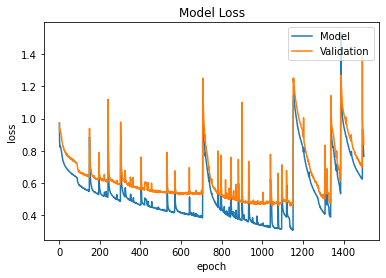

In [ ]:
epochs = range(2,int(epochs_d))
lstm_new_network.history['loss'].pop(0)
lstm_new_network.history['loss'].pop(0)
plt.plot(epochs, lstm_new_network.history['loss'])
lstm_new_network.history['val_loss'].pop(0)
lstm_new_network.history['val_loss'].pop(0)
plt.plot(epochs, lstm_new_network.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Model', 'Validation'], loc='upper right')
plt.show()

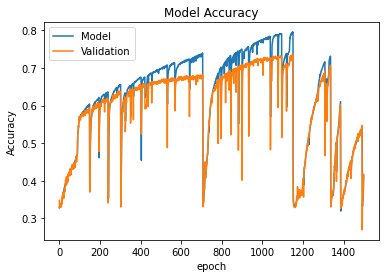

In [ ]:
plt.plot(lstm_new_network.history['categorical_accuracy'])
plt.plot(lstm_new_network.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Model', 'Validation'], loc='upper left')
plt.show()

In [18]:
# Mogelijkheid tot inladen van eerder getrained model
# Overslaan als je nieuw getrained model wil testen
new_model.load_weights('val_loss_model.h5')

In [ ]:
# Mogelijkheid tot het opslaan van het huidige model
new_model.save("test_123")

In [ ]:
# Enkel gemaakt voor cross-validation.
# Validatie en test set zijn samen gebracht zodat alle data ZEKER eens getest wordt.
X_test_temp = []

for planning in X_test:
  X_test_temp.append(planning)

for planning in X_val:
  X_test_temp.append(planning)

X_test = np.array(X_test_temp)

Vanaf hier worden ongeziene planningen getest. In de voorspelde vectoren wordt een waarschijnlijkheids-distibutie weergegeven over de verschillende klassen. Diegene met de hoogste waarschijnlijk wordt hoog gezet (1), de rest laag (0).

In [19]:
Pred_test_pr = new_model.predict(X_test)
Copy_pred = Pred_test_pr.copy()

In [20]:
for i, planning in enumerate(Pred_test_pr):
  for j, day in enumerate(Pred_test_pr[i]):
    max_value = 0
    max_value_index = -1
    for k, feature in enumerate(Pred_test_pr[i][j]):
      if max_value < feature:
        max_value = feature
        max_value_index = k
    for k, feature in enumerate(Pred_test_pr[i][j]):
      if k == max_value_index:
        Pred_test_pr[i][j][k]=1
      else:
        Pred_test_pr[i][j][k]=0

In [21]:
mask_matrix_3 = []
for planning in X_test:
  mask_row = []
  for timestamp in planning:
    if -1.0 in timestamp:
      mask_row.append(0)
    else:
      mask_row.append(1)
  mask_matrix_3.append(mask_row)

mask_matrix_3 = np.array(mask_matrix_3)
print(len(X_train))
print(str(mask_matrix_3.shape))

8744
(2209, 322)


Er wordt gekeken in hoeverre de output-planning overeenkomt met de input-planning. Dit wordt bekeken in zijn totaliteit en aan de hand daarvan worden een aantal parameters berekend.

In [22]:
procenten = []
totaal_procenten = 0

min = 1
max = 0

for planning in range(len(Pred_test_pr)):
  total = 0
  sum = 0


  for dag in range(len(Pred_test_pr[0])):
    total += mask_matrix_3[planning][dag]
    for feature in range(6):
      assert int(mask_matrix_3[planning][dag]) >= 0

      if int(mask_matrix_3[planning][dag]) > 0:
        assert int(Pred_test_pr[planning][dag][feature]) >= 0
        assert int(X_test[planning][dag][feature]) >= 0

      sum += (int(mask_matrix_3[planning][dag]) * int(Pred_test_pr[planning][dag][feature]) * int(X_test[planning][dag][feature]))
  
  percentage = float(float(sum) / float(total))
  totaal_procenten = totaal_procenten + percentage
  procenten.append(percentage)

  if percentage < min:
    min = percentage
  if percentage > max:
    max = percentage

print("This model gives you the following parameters:")
print("")
print("   - GEMIDDELDE ACCURACY IN PLANNINGEN: " + str(float(totaal_procenten / len(Pred_test_pr))))
print("   - Minumum Accuracy: " + str(min))
print("   - Maximum Accuracy: " + str(max))
print("")
print("")
print("   - ACCURACY-PERCENTAGES IN PLANNINGEN (Alles): ")
print("")
print(procenten)


This model gives you the following parameters:

   - GEMIDDELDE ACCURACY IN PLANNINGEN: 0.7850040287308429
   - Minumum Accuracy: 0.4166666666666667
   - Maximum Accuracy: 0.9682539682539683


   - ACCURACY-PERCENTAGES IN PLANNINGEN (Alles): 

[0.7362637362637363, 0.7362637362637363, 0.7692307692307693, 0.7142857142857143, 0.7472527472527473, 0.7472527472527473, 0.7692307692307693, 0.7472527472527473, 0.7472527472527473, 0.7692307692307693, 0.7142857142857143, 0.7362637362637363, 0.7692307692307693, 0.8333333333333334, 0.7857142857142857, 0.8095238095238095, 0.8571428571428571, 0.8214285714285714, 0.8095238095238095, 0.8333333333333334, 0.7619047619047619, 0.8452380952380952, 0.8095238095238095, 0.8333333333333334, 0.7380952380952381, 0.7912087912087912, 0.7472527472527473, 0.7032967032967034, 0.7472527472527473, 0.6923076923076923, 0.7692307692307693, 0.7362637362637363, 0.7252747252747253, 0.7472527472527473, 0.8021978021978022, 0.7142857142857143, 0.7472527472527473, 0.7802197802197

Hierna wordt de distributie bekeken van alle planningen, in welke range de meeste planningen liggen etc. Dit met als doel om een beter zicht te krijgen op de behaalde resultaten en de juiste conclusies te kunnen nemen.

In [ ]:
procenten.sort()
plot_x = []

for i in range(len(procenten)):
  plot_x.append(i)

plt.plot(plot_x, procenten)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Index')
plt.legend(['Accuracy'], loc='upper left')
plt.show()

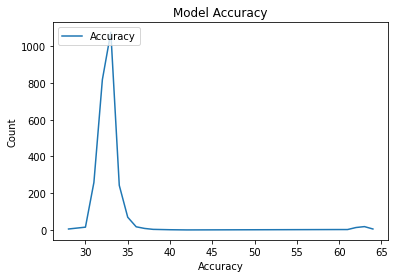

In [ ]:
import math

x_array = []
y_array = []

previous_procent = 0.0
count = 0

for procent in procenten:
  pr = math.floor(procent * 100.0)
  
  if pr > previous_procent:
    x_array.append(previous_procent)
    y_array.append(count)

    previous_procent = pr
    count = 1
  else:
    count += 1

plt.plot(x_array[1:], y_array[1:])
plt.title('Model Accuracy')
plt.ylabel('Count')
plt.xlabel('Accuracy')
plt.legend(['Accuracy'], loc='upper left')
plt.show()

Het laatste stukje is enkel van toepassing bij de analyse naar wat de ENCODER van het netwerk juist genereert.

In [23]:
enc = Model(inputs=new_model.inputs, outputs=new_model.layers[6].output)

In [ ]:
# In het geval de encoder apart moet opgeslagen worden
new_model.save("Model.h5")
enc.save("Encoder.h5")

In [24]:
Pred_enc = enc.predict(X_test)

In [28]:
# De output vector is hetzelfde voor alle tijdstippen
print(Pred_enc[0][0])

[-0.0331795  -0.0654391  -0.04613594  0.08098157  0.00275483 -0.05341297
 -0.03279207 -0.1111484  -0.02651988  0.01819679 -0.02996738  0.14611325
  0.16981038  0.01548766 -0.03039786 -0.21366401  0.1879163   0.02801559
 -0.00210228  0.19499552  0.00317754 -0.12742525 -0.03444137 -0.04644236
 -0.16228913 -0.0286677   0.00725877 -0.02060806  0.03299914  0.05334417
 -0.11790235 -0.01747469  0.08827741 -0.09290799  0.17746542  0.06048648
 -0.02098076  0.067679    0.05943598  0.01994737 -0.01586227  0.3274077
 -0.08089796  0.09652061  0.01454173  0.01014467 -0.01393649  0.07418494
  0.03396707 -0.03612947  0.02144128  0.04622207  0.04806399  0.00312421
  0.03577281  0.00606223 -0.0695929   0.05596629  0.03692439  0.14334564
 -0.00788893 -0.09206942  0.06999373 -0.0108708  -0.11494736 -0.00924975
 -0.26191533 -0.01466332  0.14741266  0.00351043 -0.03311801  0.0580795
  0.00850669  0.1315696  -0.03915621  0.08803708  0.04263645  0.12944357
 -0.0078047   0.02973285 -0.00979046 -0.07110312 -0.0